# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

# tickers = [
#     "XLC", "GOOG", "TMUS", "EA", "CMCSA", # Comms
#     "MCD", "BKNG", "NKE", "SBUX", # Cons. Disc
#     "XLP", "TGT", "MO", # Cons. Staples
#     "XLE", "XOM", "CVX", "COP", "EOG", "PXD", "WMB", # Energy
#     "XLF", "JPM", "V", "MA", "SPGI", "PGR", # Financials
#     "JNJ", "MRK", "TMO", "PFE", "AMGN", # Health
#     "CAT", "GE", "UNP", "RTX", "HON", "ETN", "UPS", "DE", "ADP", # Industrials
#     "LIN", "SHW", "ECL", "APD", "NUE", "CTVA", "MLM", # Materials
#     "XLRE", "AMT", "EQIX", "WELL", "SPG", "O", "PSA", "CCI", "CSGP", # Real Estate
#     "XLK", "AVGO", "ORCL", # Tech
#     "XLU", "SO", "AEP", "D", "EXC", # Utilities
# ]

tickers = ['XLC','NKE','XLP','XLE','JPM','JNJ','CAT','LIN','XLRE','XLK','XLU']

ex_stock='XLC'

[*********************100%%**********************]  11 of 11 completed


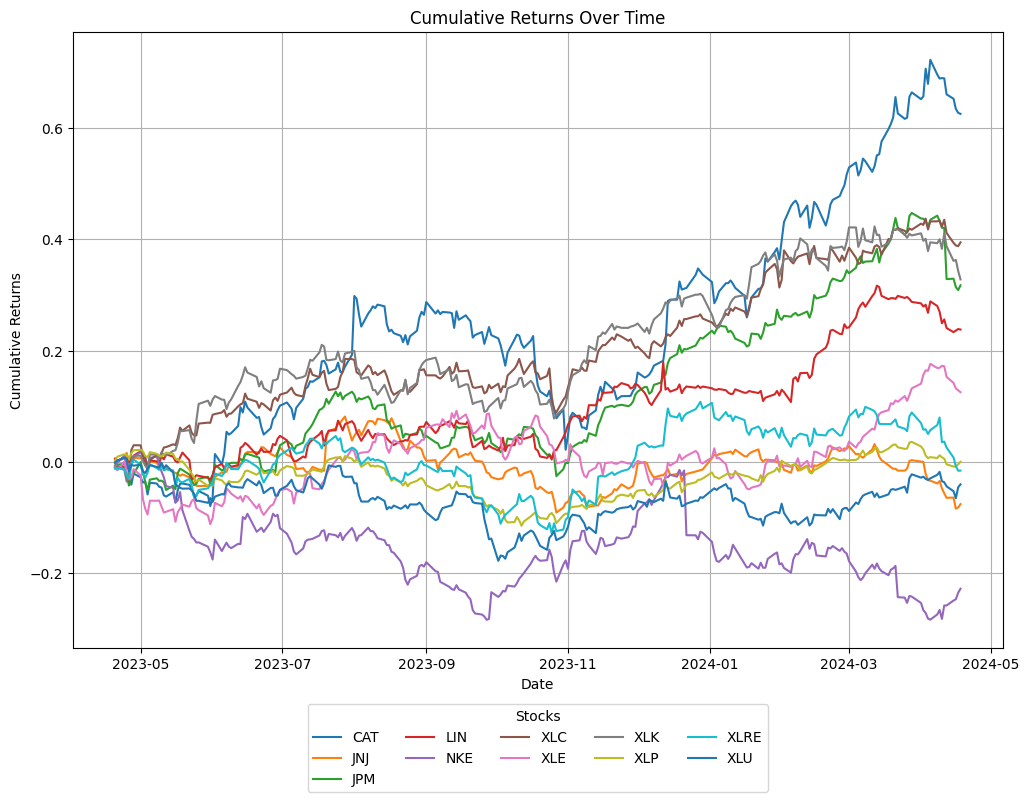

In [3]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [4]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [5]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=0.2)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.24717753160885947
Initial Port Volatility: 0.07173248983642586
Initial Port Sharpe: 2.8589211398698837
Optimal Weights: {'CAT': 0.147, 'JNJ': -0.078, 'JPM': 0.154, 'LIN': 0.1, 'NKE': -0.13, 'XLC': 0.2, 'XLE': -0.012, 'XLK': 0.013, 'XLP': -0.0, 'XLRE': -0.167, 'XLU': -0.0}


In [6]:
with open('Data\\init_sim_port_weights.pkl', 'wb') as handle:
    pickle.dump(init_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

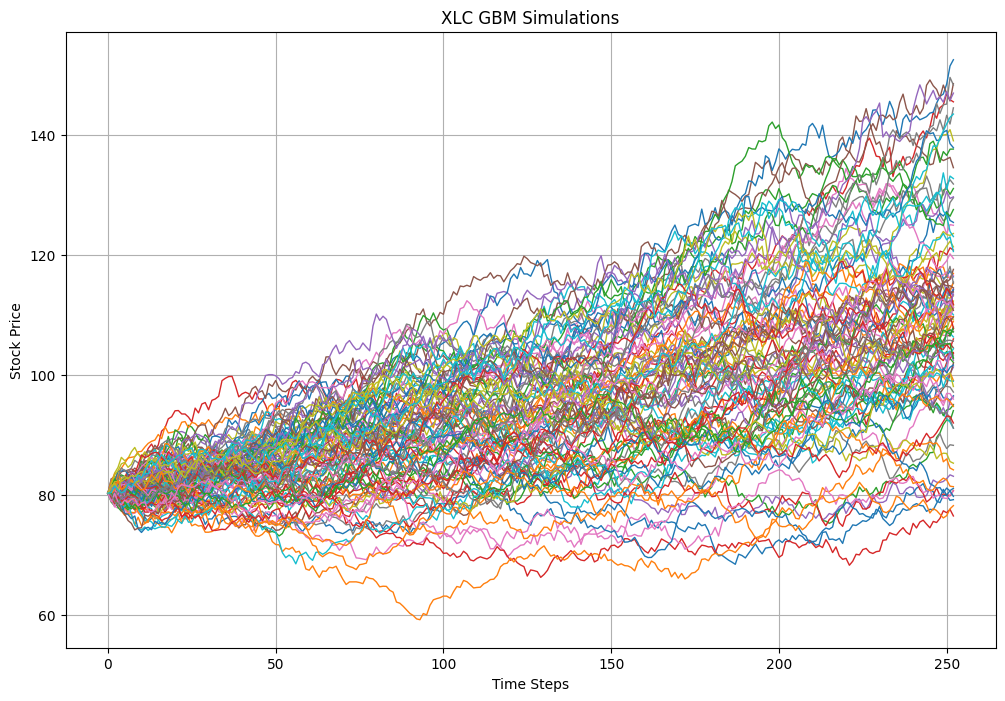

In [7]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

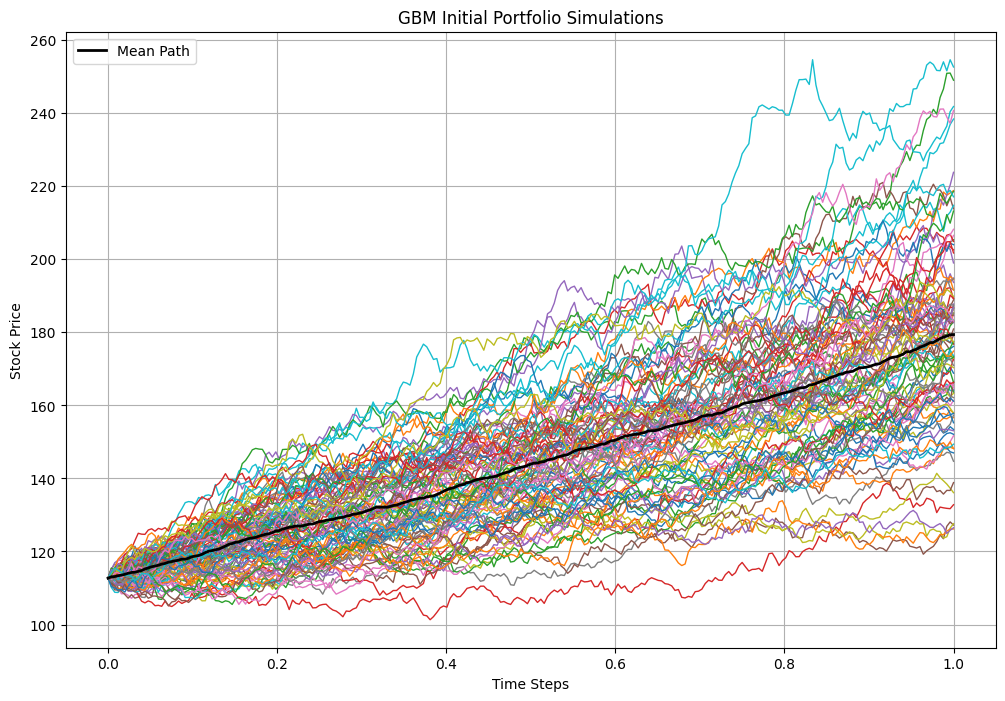

In [8]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [9]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
gbm_std_dev_returns=np.mean(gbm_init_port.std(axis=1)*np.sqrt(1/252))
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')
print(f'GBM Initial Portfolio Sharpe: {round((gbm_ret-risk_free_rate)/gbm_std_dev_returns,4)}')

GBM Initial Portfolio Return: 56.14%
GBM Initial Portfolio Sharpe: 0.4283


### Merton Jump Diffusion: 

In [10]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

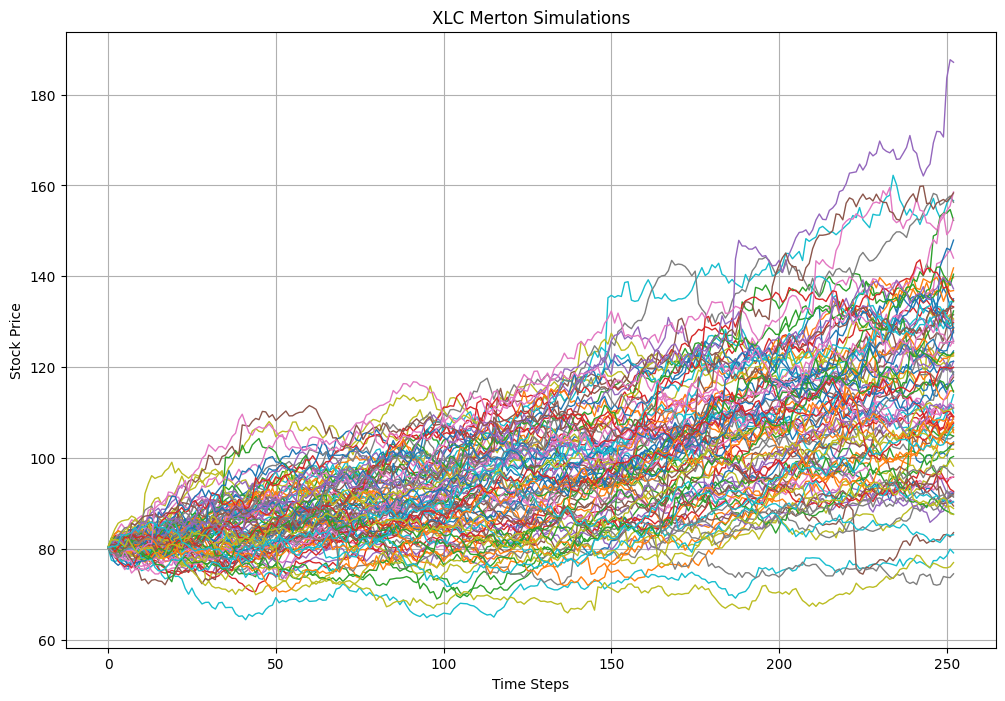

In [11]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

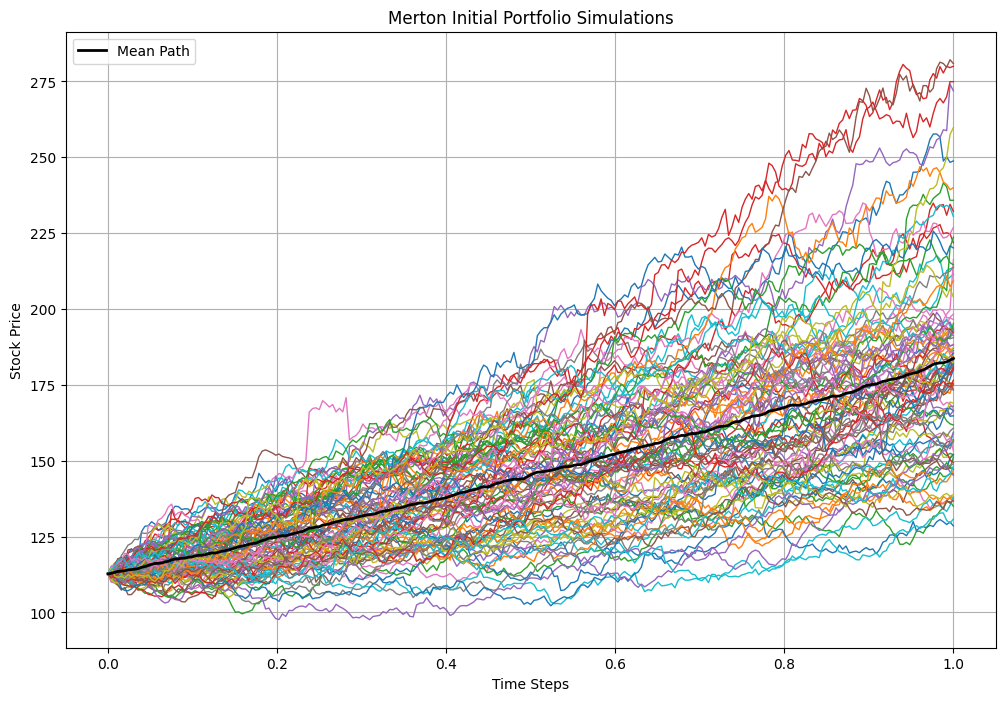

In [12]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [13]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')
merton_std_dev_returns=np.mean(merton_init_port.std(axis=1)*np.sqrt(1/252))
print(f'Merton Initial Portfolio Sharpe: {round((merton_ret-risk_free_rate)/merton_std_dev_returns,4)}')

Merton Initial Portfolio Return: 65.9%
Merton Initial Portfolio Sharpe: 0.4317


### Constant Elasticity of Variance (CEV): 

Estimated XLC CEV Parameters: mu=0.001233065953296277, std=0.7290673065718554, gamma=0.0


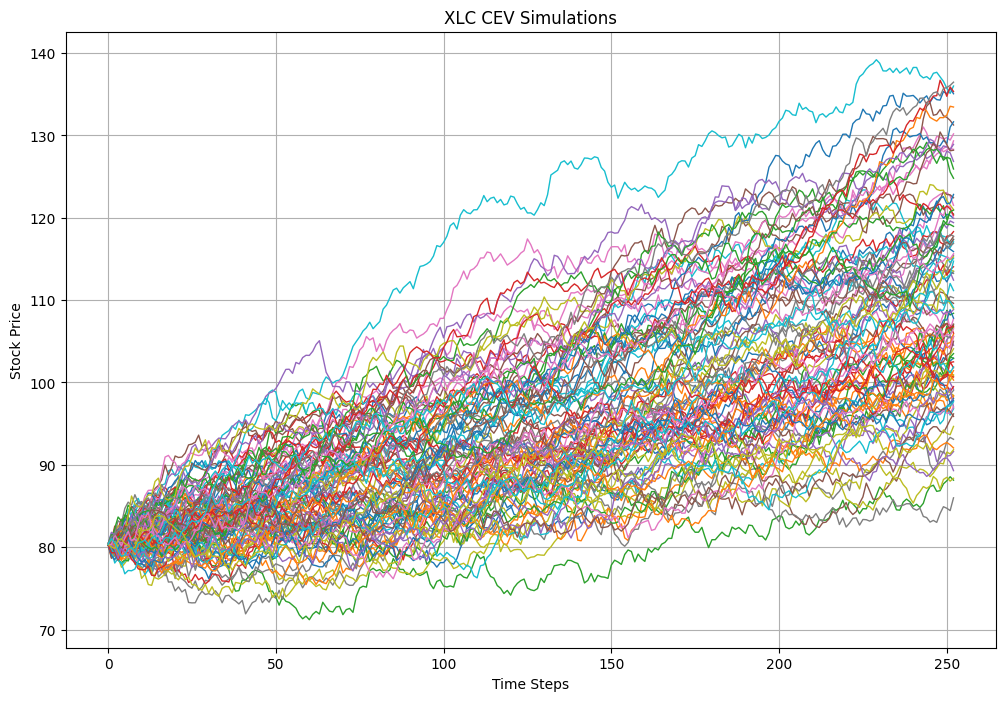

In [14]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

In [15]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

Estimated CAT CEV Parameters: mu=0.0019521763809094105, std=2.472293750024077, gamma=0.10276475122157588
Estimated JNJ CEV Parameters: mu=-0.0002647313995694088, std=5.997954157568284e-05, gamma=2.0
Estimated JPM CEV Parameters: mu=0.0011668442828789082, std=0.004276013209106984, gamma=1.1802476250389915
Estimated LIN CEV Parameters: mu=0.0008649340797036804, std=0.20180585850809904, gamma=0.5021241081043908


In [ ]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')
cev_std_dev_returns=np.mean(cev_init_port.std(axis=1)*np.sqrt(1/252))
print(f'CEV Initial Portfolio Sharpe: {round((cev_ret-risk_free_rate)/cev_std_dev_returns,4)}')

CEV Initial Portfolio Return: 55.31%
CEV Initial Portfolio Sharpe: 0.438


### Heston Model:

Estimated XLC Heston Parameters: theta=0.12271133538906136, kappa=6.958238541635703, sigma=0.6244590130555829, rho=-0.9999999321972346, v0=0.012390476974494729


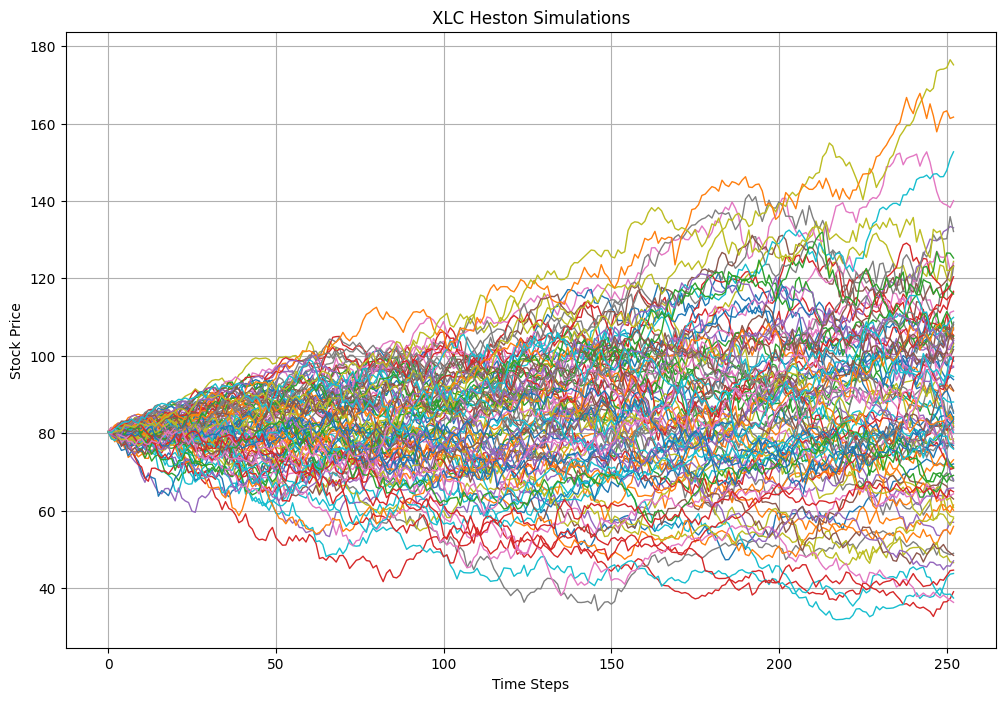

In [ ]:
ex_heston_param=dat_func.estimate_heston_params(ex_stock,end_date,stock_df,risk_free_rate)
ex_heston_prices=dat_func.simulate_heston(ex_heston_param, stock_df[ex_stock][-1], risk_free_rate)
vis.plot_paths(ex_heston_prices[:100],f'{ex_stock} Heston')

Estimated CAT Heston Parameters: theta=0.12605059708478888, kappa=2.654405081134451, sigma=0.5832693598958067, rho=-0.9999996277066547, v0=0.015079615628514792
Estimated JNJ Heston Parameters: theta=4.561443104127508, kappa=1.6381361566096664, sigma=8.847021055771421, rho=-0.9997823103554059, v0=0.6441408283356238
Estimated JPM Heston Parameters: theta=0.07509078674376403, kappa=3.705957348011468, sigma=0.6078337293705918, rho=-0.9999867201001257, v0=0.012315062637746415
Estimated LIN Heston Parameters: theta=0.6331480499302584, kappa=10.004287523978004, sigma=0.3615293207496042, rho=-0.9999904411884715, v0=0.030590927014267844
Estimated NKE Heston Parameters: theta=1.3826406153815727, kappa=28.227356268370308, sigma=2.334494950711062, rho=-0.565129404434604, v0=8.434238683439344e-08
Estimated XLC Heston Parameters: theta=0.12271133538906136, kappa=6.958238541635703, sigma=0.6244590130555829, rho=-0.9999999321972346, v0=0.012390476974494729
Estimated XLE Heston Parameters: theta=0.1146

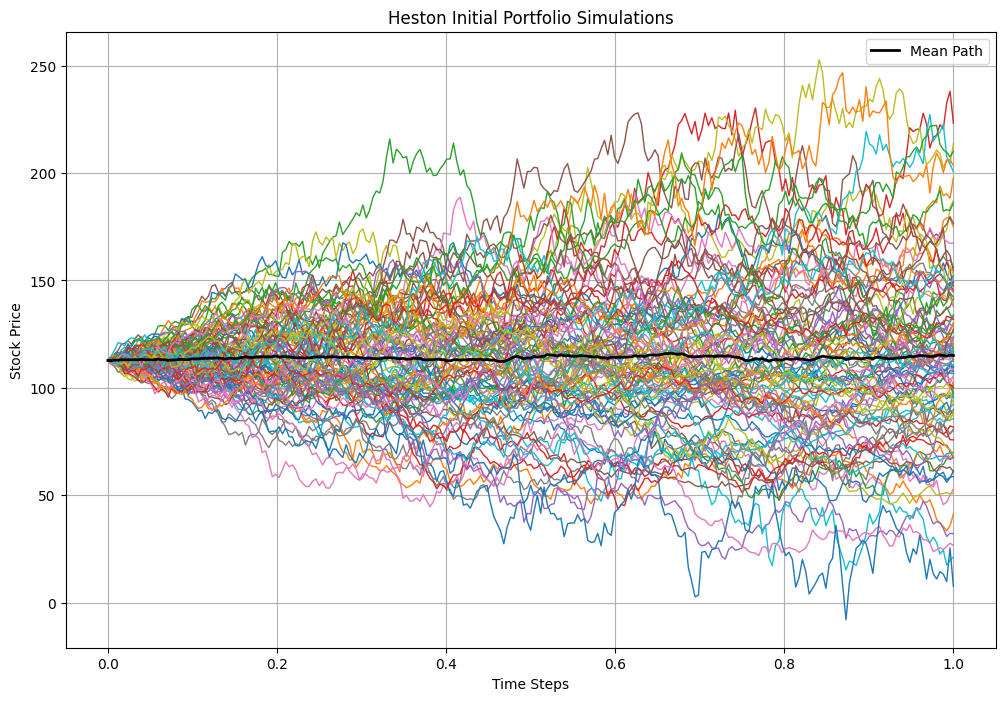

In [ ]:
heston_init_port=dat_func.simulate_heston_portfolio(stock_df,init_weights,risk_free_rate)
vis.plot_paths(heston_init_port.iloc[:100],'Heston Initial Portfolio',True)

In [ ]:
heston_ret=(heston_init_port.mean(axis=0).iloc[-1]-heston_init_port.mean(axis=0).iloc[0])/heston_init_port.mean(axis=0).iloc[0]
print(f'Heston Initial Portfolio Return: {round(heston_ret*100,2)}%')
hest_std_dev_returns=np.mean(heston_init_port.std(axis=1)*np.sqrt(1/252))
print(f'GBM Initial Portfolio Sharpe: {round((heston_ret-risk_free_rate)/hest_std_dev_returns,4)}')

Heston Initial Portfolio Return: 4.42%
GBM Initial Portfolio Sharpe: 0.002


## Simulation Portfolio:

In [ ]:
sim_port_results=dat_func.calculate_simulate_portfolio(tickers,end_date,stock_df,returns_df,risk_free_rate,0.2,100)
sim_port_weights={tick:sim_port_results.x[i] for i,tick in enumerate(tickers)}

Estimated XLC CEV Parameters: mu=0.001233065953296277, std=0.7290673065718554, gamma=0.0
Estimated XLC Heston Parameters: theta=0.12271133538906136, kappa=6.958238541635703, sigma=0.6244590130555829, rho=-0.9999999321972346, v0=0.012390476974494729
Estimated NKE CEV Parameters: mu=-0.0005236930782148647, std=0.00020528435454282416, gamma=1.9523137104207684
Estimated NKE Heston Parameters: theta=1.424199159240681, kappa=29.315334798576778, sigma=2.287051567846224, rho=-0.5343438695767658, v0=2.8393432909887358e-08
Estimated XLP CEV Parameters: mu=-1.986098031862608e-05, std=0.46882505939904845, gamma=0.0
Estimated XLP Heston Parameters: theta=0.23650675879014327, kappa=6.360565535331183, sigma=0.6607171240652927, rho=-0.999995325329942, v0=0.011261282107928912
Estimated XLE CEV Parameters: mu=0.0004484813488308496, std=1.0066875423241033, gamma=0.0
Estimated XLE Heston Parameters: theta=1.3990909969952736, kappa=17.364013263510802, sigma=0.565747736609749, rho=-0.9999999580707307, v0=0.

{'XLC': 0.00017648499040559133,
 'NKE': 0.1999999999999782,
 'XLP': -0.0030084365910817644,
 'XLE': 0.19999999999999854,
 'JPM': 0.2,
 'JNJ': 2.1550452502360813e-05,
 'CAT': 0.19999999999998977,
 'LIN': -0.00018877498513453412,
 'XLRE': 0.2,
 'XLK': 0.0038737812422882235,
 'XLU': -0.0004785342231694639}

In [ ]:
with open('Data\\full_sim_port_weights.pkl', 'wb') as handle:
    pickle.dump(sim_port_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

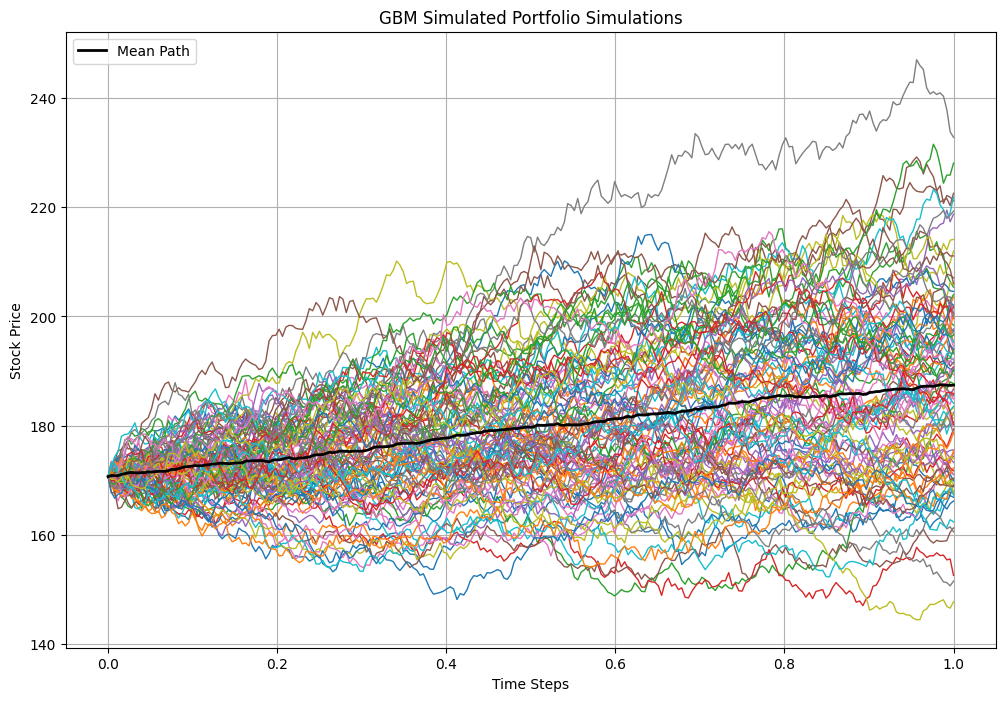

In [ ]:
gbm_sim_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,list(sim_port_weights.values()))
vis.plot_paths(gbm_sim_port.iloc[:100],'GBM Simulated Portfolio',True)

In [ ]:
gbm_sim_ret=(gbm_sim_port.mean(axis=0).iloc[-1]-gbm_sim_port.mean(axis=0).iloc[0])/gbm_sim_port.mean(axis=0).iloc[0]
gbm_sim_std_dev_returns=np.mean(gbm_sim_port.std(axis=1)*np.sqrt(1/252))
print(f'GBM Simulated Portfolio Return: {round(gbm_sim_ret*100,2)}%')
print(f'GBM Simulated Portfolio Sharpe: {round((gbm_sim_ret-risk_free_rate)/gbm_sim_std_dev_returns,4)}')

GBM Initial Portfolio Return: 9.81%
GBM Initial Portfolio Sharpe: 0.109


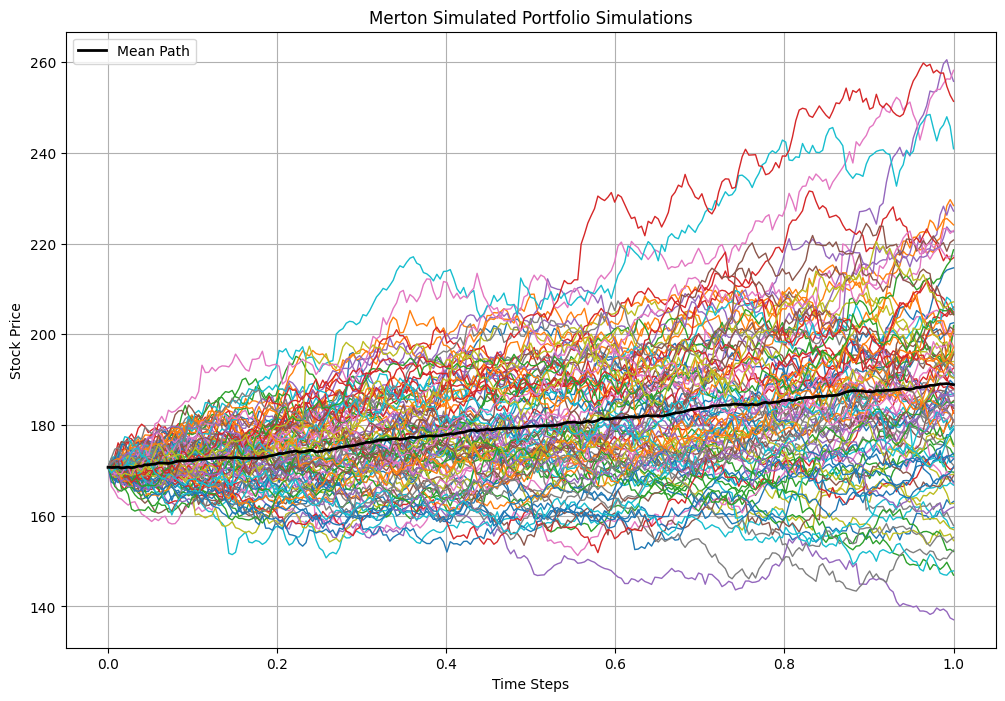

In [ ]:
merton_sim_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,list(sim_port_weights.values()))
vis.plot_paths(merton_sim_port.iloc[:100],'Merton Simulated Portfolio',True)

In [ ]:
merton_sim_ret=(merton_sim_port.mean(axis=0).iloc[-1]-merton_sim_port.mean(axis=0).iloc[0])/merton_sim_port.mean(axis=0).iloc[0]
merton_sim_std_dev_returns=np.mean(merton_sim_port.std(axis=1)*np.sqrt(1/252))
print(f'Merton Simulated Portfolio Return: {round(merton_sim_ret*100,2)}%')
print(f'Merton Simulated Portfolio Sharpe: {round((merton_sim_ret-risk_free_rate)/merton_sim_std_dev_returns,4)}')

GBM Initial Portfolio Return: 9.16%
GBM Initial Portfolio Sharpe: 0.0911


Estimated CAT CEV Parameters: mu=0.0019521951152014153, std=2.474142106202001, gamma=0.10263158808033002
Estimated JNJ CEV Parameters: mu=-0.00020100996862756811, std=6.197032514971804e-05, gamma=1.9935340041298264
Estimated JPM CEV Parameters: mu=0.001166798664196985, std=0.0042767783223361475, gamma=1.1802143574854331
Estimated LIN CEV Parameters: mu=0.0008649340797036804, std=0.20180585850809904, gamma=0.5021241081043908
Estimated NKE CEV Parameters: mu=-0.0005236930782148647, std=0.00020528435454282416, gamma=1.9523137104207684
Estimated XLC CEV Parameters: mu=0.001233065953296277, std=0.7290673065718554, gamma=0.0
Estimated XLE CEV Parameters: mu=0.0004484813488308496, std=1.0066875423241033, gamma=0.0
Estimated XLK CEV Parameters: mu=0.0010732135383153612, std=0.17250113460298225, gamma=0.4724094316552548
Estimated XLP CEV Parameters: mu=-1.986098031862608e-05, std=0.46882505939904845, gamma=0.0
Estimated XLRE CEV Parameters: mu=-0.00012692140635152917, std=0.42259959351640597, g

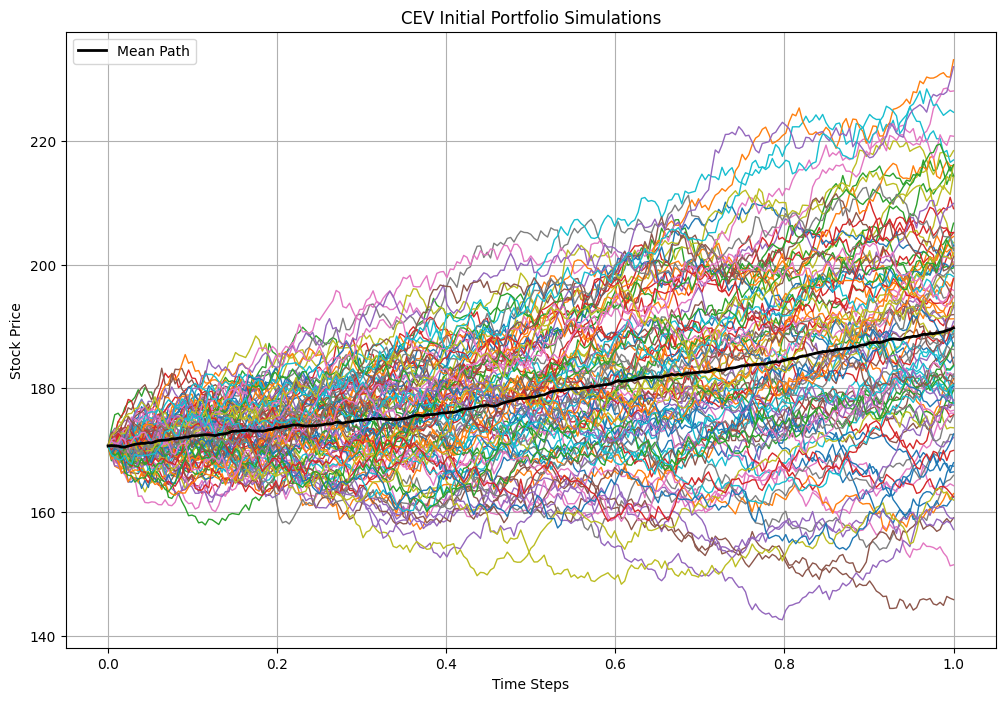

In [ ]:
cev_sim_port=dat_func.simulate_cev_portfolio(stock_df,list(sim_port_weights.values()))
vis.plot_paths(cev_sim_port.iloc[:100],'CEV Simulated Portfolio',True)

In [ ]:
cev_sim_ret=(cev_sim_port.mean(axis=0).iloc[-1]-cev_sim_port.mean(axis=0).iloc[0])/cev_sim_port.mean(axis=0).iloc[0]
cev_sim_std_dev_returns=np.mean(cev_sim_port.std(axis=1)*np.sqrt(1/252))
print(f'CEV Simulated Portfolio Return: {round(cev_sim_ret*100,2)}%')
print(f'CEV Simulated Portfolio Sharpe: {round((cev_sim_ret-risk_free_rate)/cev_sim_std_dev_returns,4)}')

CEV Simulated Portfolio Return: 11.61%
CEV Simulated Portfolio Sharpe: 0.1454


Estimated CAT Heston Parameters: theta=0.12605059735836982, kappa=2.654405111277119, sigma=0.5832693601090368, rho=-0.9999996261358808, v0=0.015079615571656046
Estimated JNJ Heston Parameters: theta=4.561443104127508, kappa=1.6381361566096664, sigma=8.847021055771421, rho=-0.9997823103554059, v0=0.6441408283356238
Estimated JPM Heston Parameters: theta=0.07509078674376403, kappa=3.705957348011468, sigma=0.6078337293705918, rho=-0.9999867201001257, v0=0.012315062637746415
Estimated LIN Heston Parameters: theta=0.6331480499302584, kappa=10.004287523978004, sigma=0.3615293207496042, rho=-0.9999904411884715, v0=0.030590927014267844
Estimated NKE Heston Parameters: theta=1.3826406153815727, kappa=28.227356268370308, sigma=2.334494950711062, rho=-0.565129404434604, v0=8.434238683439344e-08
Estimated XLC Heston Parameters: theta=0.122711335389944, kappa=6.958238541537335, sigma=0.6244590130561665, rho=-0.9999999322028444, v0=0.01239047697432716
Estimated XLE Heston Parameters: theta=0.0659863

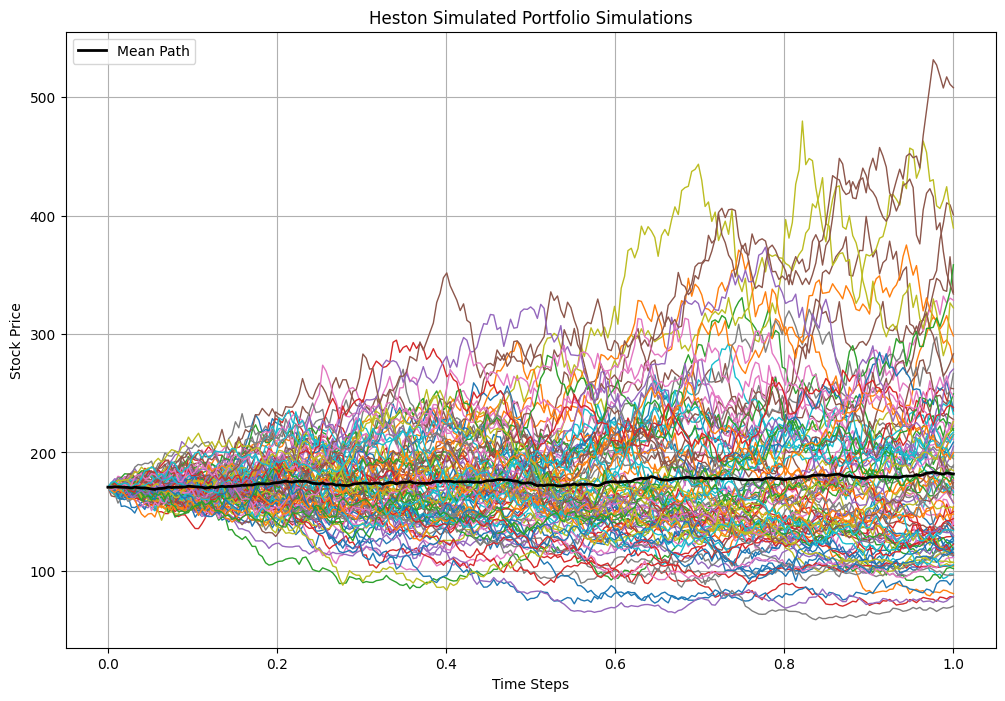

In [ ]:
heston_sim_port=dat_func.simulate_heston_portfolio(stock_df,list(sim_port_weights.values()),risk_free_rate)
vis.plot_paths(heston_sim_port.iloc[:100],'Heston Simulated Portfolio',True)

In [ ]:
heston_sim_ret=(heston_sim_port.mean(axis=0).iloc[-1]-heston_sim_port.mean(axis=0).iloc[0])/heston_sim_port.mean(axis=0).iloc[0]
heston_port_sim_std_dev_returns=np.mean(heston_sim_port.std(axis=1)*np.sqrt(1/252))
print(f'Heston Simulated Portfolio Return: {round(heston_sim_ret*100,2)}%')
print(f'Heston Simulated Portfolio Sharpe: {round((heston_sim_ret-risk_free_rate)/heston_port_sim_std_dev_returns,4)}')

Heston Simulated Portfolio Return: 3.44%
Heston Simulated Portfolio Sharpe: -0.0041
